# Fine-tune Llama 2 on legal dataset
Based on Younes Belkada's [GitHub Gist](https://gist.github.com/younesbelkada/9f7f75c94bdc1981c8ca5cc937d4a4da).

This notebook runs on a T4 GPU.

In [3]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00


In [4]:
import os
import torch
from datasets import load_dataset


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! mkdir "/root/.huggingface"

In [7]:
! cp "drive/MyDrive/.huggingface/token" /root/.huggingface/token

In [7]:
! mkdir /content/drive/MyDrive/Llama-2/

mkdir: cannot create directory ‘/content/drive/MyDrive/Llama-2/’: File exists


In [8]:
! mkdir /content/drive/MyDrive/Llama-2/llama-2-7b-mini-legal-chat

mkdir: cannot create directory ‘/content/drive/MyDrive/Llama-2/llama-2-7b-mini-legal-chat’: File exists


In [9]:
! mkdir /content/drive/MyDrive/Llama-2/data

mkdir: cannot create directory ‘/content/drive/MyDrive/Llama-2/data’: File exists


In [10]:
! mkdir /content/drive/MyDrive/Llama-2/data/Lawyer-Instruct

mkdir: cannot create directory ‘/content/drive/MyDrive/Llama-2/data/Lawyer-Instruct’: File exists


In [12]:
data_dir = "/content/drive/MyDrive/Llama-2/data/Lawyer-Instruct"

In [13]:
# ??load_dataset

In [15]:
# The instruction dataset to use
dataset_name = "Alignment-Lab-AI/Lawyer-Instruct"

In [16]:
# Load dataset (MAKE SURE DATA DIR IS ON VOLUME WITH ENOUGH CAPACITY)
#  I.E. not on google colab local store, it helps with iterating multiple times
# on same data.
dataset = load_dataset(dataset_name)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_hf_folder.py:95: UserWarning: A token has been found in `/root/.huggingface/token`. This is the old path where tokens were stored. The new location is `/root/.cache/huggingface/token` which is configurable using `HF_HOME` environment variable. Your token has been copied to this new location. You can now safely delete the old token file manually or use `huggingface-cli logout`.
  warnings.warn(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'instruction', 'output'],
        num_rows: 9241
    })
})

In [18]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_sequence_lengths(dataset_obj):

    # Initialize a list to store the sequence lengths
    sequence_lengths = []

    # list of indices that are too long
    too_long = []

    # Loop over the dataset and get the lengths of text sequences
    for idx, example in enumerate(dataset_obj["train"]):
        sequence_lengths.append(len(example['instruction']) + len(example["input"]) + len(example["output"]))
        if sequence_lengths[idx] > 2200:
          too_long.append(idx)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return too_long

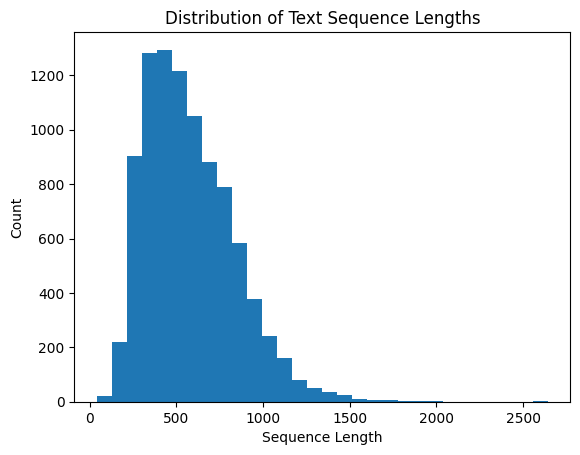

In [19]:
indexes_to_drop = plot_sequence_lengths(dataset)

In [20]:
len(indexes_to_drop)

1

In [21]:
dataset_reduced = dataset["train"].select(
    i for i in range(len(dataset["train"])) if i not in set(indexes_to_drop)
)

Parameter 'indices'=<generator object <genexpr> at 0x78776019fd10> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [22]:
dataset_prepared = dataset_reduced.train_test_split(test_size=0.1)

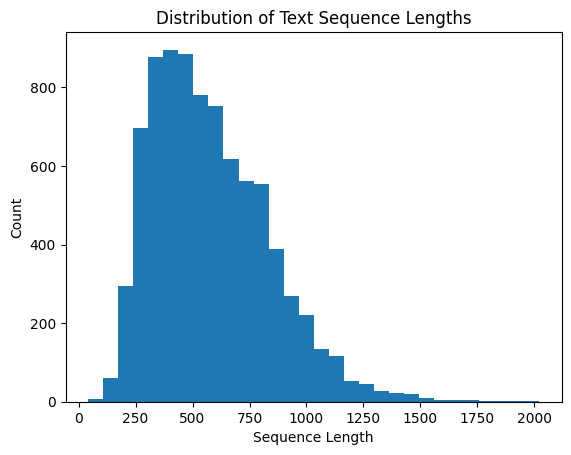

In [23]:
indexes_to_drop = plot_sequence_lengths(dataset_prepared)

In [24]:
len(indexes_to_drop)

0

In [25]:
dataset_prepared

DatasetDict({
    train: Dataset({
        features: ['input', 'instruction', 'output'],
        num_rows: 8316
    })
    test: Dataset({
        features: ['input', 'instruction', 'output'],
        num_rows: 924
    })
})

In [26]:
print("instruction: ", dataset_prepared["train"][2]["instruction"], "\ninput: ", dataset_prepared["train"][2]["input"])

instruction:  The first piece of information discusses a case where a cy pres distribution was deemed an abuse of discretion because there was no reasonable certainty that any class member would benefit from it. The choice of charity and its relation to the class members and claims figured heavily in the analysis. The purpose of the statute was to compensate victims of unscrupulous employers and to deter future violations, but the chosen charity was not limited in its choice of projects and any distribution would require court supervision. 
input:  


In [27]:
print("instruction: ", dataset_prepared["train"][21]["instruction"], "\ninput: ", dataset_prepared["train"][21]["input"])

instruction:  I agree. The charges were not unconstitutionally vague as applied, and the evidence was sufficient to sustain the convictions. 
input:  


In [28]:
print("instruction: ", dataset_prepared["train"][200]["instruction"], "\ninput: ", dataset_prepared["train"][200]["input"])

instruction:  The first piece of information appears to be a clause in an agreement that requires any disputes or breaches to be settled through arbitration in Los Angeles County. This suggests that any legal action related to the agreement must go through arbitration rather than the court system. 
input:  


In [29]:
print("instruction: ", dataset_prepared["train"][32]["instruction"], "\ninput: ", dataset_prepared["train"][32]["input"])

instruction:  Okay, let's break this down. We have three pieces of information. The first is that the court denied American's motion for a new trial based on their reasoning for the jury instructions. 
input:  


In [30]:
# Before we can begin training, we need to set up a few helper functions to
# ensure our dataset is parsed in the correct format and we save our PEFT adapters!

In [41]:
# def formatting_func(example):
#   if example.get("context", "") != "":
#       input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
#       "Write a response that appropriately completes the request.\n\n"
#       "### Instruction:\n"
#       f"{example['instruction']}\n\n"
#       f"### Input: \n"
#       f"{example['input']}\n\n"
#       f"### Response: \n"
#       f"{example['output']}")

#   else:
#     input_prompt = (f"Below is an instruction that describes a task. "
#       "Write a response that appropriately completes the request.\n\n"
#       "### Instruction:\n"
#       f"{example['instruction']}\n\n"
#       f"### Response:\n"
#       f"{example['output']}")

#   return {"text" : input_prompt}


def formatting_func(example):
    input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\n"
    f"Generate a response that appropriately completes the input.\n\n"
    f"### Input: \n"
    f"{example['instruction']}\n\n"
    f"### Response: \n"
    f"{example['output']}")

    return {"text" : input_prompt}

In [42]:
formatted_dataset = dataset_prepared.map(formatting_func)

Map:   0%|          | 0/8316 [00:00<?, ? examples/s]

Map:   0%|          | 0/924 [00:00<?, ? examples/s]

In [43]:
formatted_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'instruction', 'output', 'text'],
        num_rows: 8316
    })
    test: Dataset({
        features: ['input', 'instruction', 'output', 'text'],
        num_rows: 924
    })
})

In [44]:
formatted_dataset["train"][2]["text"]

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a response that appropriately completes the input.\n\n### Input: \nThe first piece of information discusses a case where a cy pres distribution was deemed an abuse of discretion because there was no reasonable certainty that any class member would benefit from it. The choice of charity and its relation to the class members and claims figured heavily in the analysis. The purpose of the statute was to compensate victims of unscrupulous employers and to deter future violations, but the chosen charity was not limited in its choice of projects and any distribution would require court supervision.\n\n### Response: \nThe second piece of information discusses a case where damages would be small and distribution to the class prohibitively expensive, so AOL agreed to make substantial donations to three chariti

In [45]:
formatted_dataset["train"][22]["text"]

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a response that appropriately completes the input.\n\n### Input: \nAgreed. We should continue this process until we reach a conclusion that we all agree on. We should also provide commentary to support our answer and explain how we arrived at our conclusion.\n\n### Response: \nYes, and we should be open to feedback and critique from our colleagues. This will help us refine our thinking and ensure that we've considered all the relevant factors."

In [46]:
formatted_dataset["train"][27]["text"]

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a response that appropriately completes the input.\n\n### Input: \nBut the court is saying that it can use higher rates if local counsel is unavailable.\n\n### Response: \nAnd the court can use those rates either in calculating the initial lodestar figure or in evaluating whether to award a multiplier to a lodestar initially based on local hourly rates.'

In [47]:
formatted_dataset["train"][121]["text"]

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a response that appropriately completes the input.\n\n### Input: \nHmm, based on the information provided, it seems like we need to generate reasoning traces and task-specific actions in an interleaved manner. We need to start with incomplete information and prompt for the need to get additional helpful information at each step. This will allow us to dynamically create, maintain, and adjust high-level plans for acting while also interacting with external sources to incorporate additional information into reasoning. Let's start by identifying what additional information we need to gather.\n\n### Response: \nI think we need to treat this problem as a search over a tree structure, with each node representing a partial solution and the branches corresponding to operators that modify the solution. We need

In [48]:
formatted_dataset["test"][11]["text"]

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a response that appropriately completes the input.\n\n### Input: \nBased on the information provided, it seems like we need to generate reasoning traces and task-specific actions in an interleaved manner. We can start by identifying the potential dangers associated with delayed response times and then prompt for the need to get additional helpful information at each step. This will allow us to dynamically reason and create, maintain, and adjust high-level plans for acting while also interacting with external sources to incorporate additional information into reasoning.\n\n### Response: \nI agree that we need to explore multiple reasoning paths over thoughts to find a solution. We can treat the problem as a search over a tree structure, with each node representing a partial solution and the branches c

In [49]:
formatted_dataset["test"][3]["text"]

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a response that appropriately completes the input.\n\n### Input: \nThe majority seems to be ignoring the conditional nature of the construction permit. They acknowledge that the permit is conditioned upon completion of the administrative or judicial review of the reallotment, but then assert that the condition is no condition at all. This strikes me as paradoxical.\n\n### Response: \nThe majority's rejection of the contractual language is flawed. They offer little more than an ipse dixit, claiming that the parties would have used other language if they meant to require that the reallotment become a final order before the construction permit could follow suit. However, the condition in the construction permit linking the permit to the judicial review of the reallotment was created by the FCC after the

In [50]:
formatted_dataset["test"][23]["text"]

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a response that appropriately completes the input.\n\n### Input: \nAdditionally, it seems that the plaintiffs in intervention were not successful in their request for sanctions in the second case.\n\n### Response: \nThe orders granting summary adjudication of the fraud cause of action in favor of James Philpot, James Musser, and Richard Philpot were affirmed in the third case, but the nonsuit orders in favor of defendants were also affirmed.'

In [51]:
# The model that you want to train from the Hugging Face hub
model_name = "meta-llama/Llama-2-7b-chat-hf"

# Fine-tuned model name
new_model = "mchablani/Llama-2-7b-chat-hf-mini-lawyer-chat"


In [52]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [55]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, "float16")
use_4bit = True

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)


# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)




In [56]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [57]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [58]:
# Output directory where the model predictions and checkpoints will be stored
output_dir = "/content/drive/MyDrive/Llama-2/llama-2-7b-mini-legal-chat"

In [62]:
# Number of training epochs
num_train_epochs = 1

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 1e-5

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 10

# Log every X updates steps
logging_steps = 25

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = True
bf16 = False

In [63]:
# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

trainer = SFTTrainer(
    model=model,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["test"],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/8316 [00:00<?, ? examples/s]

Map:   0%|          | 0/924 [00:00<?, ? examples/s]

In [64]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,2.583900
50,2.724800
75,2.478700
100,2.417300
125,2.173400
150,1.959200
175,1.858400
200,1.646100
225,1.695300
250,1.467000


KeyboardInterrupt: ignored

In [65]:
# Save trained model
trainer.model.save_pretrained(new_model)

In [47]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [44]:
# # Empty VRAM
# del model
# del trainer
# import gc
# gc.collect()
# gc.collect()

0

In [56]:
# import gc
# gc.collect()

0

In [67]:
# ! nvidia-smi

In [69]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16
)
model = PeftModel.from_pretrained(base_model, new_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [70]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (v_proj):

In [71]:

# model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [1]:
# !huggingface-cli login

/bin/bash: line 1: huggingface-cli: command not found


In [12]:
model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)

Evaluate

In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer
from peft import LoraConfig, get_peft_model

# Fine-tuned model name
new_model = "mchablani/Llama-2-7b-chat-hf-mini-lawyer-chat"

compute_dtype = getattr(torch, "float16")
use_4bit = True

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

lora_config = LoraConfig.from_pretrained(new_model)

base_model = AutoModelForCausalLM.from_pretrained(
    lora_config.base_model_name_or_path,
    quantization_config=bnb_config)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_hf_folder.py:95: UserWarning: A token has been found in `/root/.huggingface/token`. This is the old path where tokens were stored. The new location is `/root/.cache/huggingface/token` which is configurable using `HF_HOME` environment variable. Your token has been copied to this new location. You can now safely delete the old token file manually or use `huggingface-cli logout`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
model = get_peft_model(base_model, lora_config)

In [10]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (

In [11]:
# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(new_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [13]:
from IPython.display import display, Markdown

# def make_inference(model, tokenizer, instruction, input = None):
#   if input:
#     prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
#   else:
#     prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
#   inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
#   outputs = model.generate(**inputs, max_new_tokens=400)
#   display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
#   outputs = model.generate(**inputs, max_new_tokens=50)
#   print("---- NON-INSTRUCT-TUNED-MODEL ----")
#   display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))

def make_inference(model, tokenizer, input):
  prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\n"
    f"Generate a response that appropriately completes the input.\n\n"
    f"### Input: \n"
    f"{input}\n\n"
    f"### Response: \n")
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  outputs = model.generate(**inputs, max_new_tokens=400)
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))



In [15]:
make_inference(model, tokenizer, "Okay, let's break this down. On December X, Russell and TAFM filed a notice of appeal to this court after hearing nothing from the district court on their intervention or stay motions.")

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Generate a response that appropriately completes the input.

### Input: 
Okay, let's break this down. On December X, Russell and TAFM filed a notice of appeal to this court after hearing nothing from the district court on their intervention or stay motions.

### Response: 
Thank you for providing the additional context. Based on the information provided, I recommend that we file a motion for an extension of time to file the notice of appeal, as it has been over 30 days since the district court last acted on their motions. This will ensure that we do not miss any deadlines and give the court sufficient time to consider our appeal.

In [17]:
make_inference(base_model, tokenizer, "Okay, let's break this down. On December X, Russell and TAFM filed a notice of appeal to this court after hearing nothing from the district court on their intervention or stay motions.")

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Generate a response that appropriately completes the input.

### Input: 
Okay, let's break this down. On December X, Russell and TAFM filed a notice of appeal to this court after hearing nothing from the district court on their intervention or stay motions.

### Response: 
Given the information provided, I recommend that we file a motion to dismiss the appeal based on the lack of jurisdiction. As the district court did not provide any response to Russell and TAFM's intervention or stay motions, it is unclear whether the court had jurisdiction over the matter. Therefore, it is likely that the appeal is invalid and should be dismissed.

In [19]:
make_inference(model, tokenizer, "The majority seems to be ignoring the conditional nature of the construction permit. They acknowledge that the permit is conditioned upon completion of the administrative or judicial review of the reallotment, but then assert that the condition is no condition at all. This strikes me as paradoxical.")

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Generate a response that appropriately completes the input.

### Input: 
The majority seems to be ignoring the conditional nature of the construction permit. They acknowledge that the permit is conditioned upon completion of the administrative or judicial review of the reallotment, but then assert that the condition is no condition at all. This strikes me as paradoxical.

### Response: 
I understand your concern about the apparent paradox surrounding the conditional nature of the construction permit. It appears that the majority is misunderstanding the implications of the permit's condition. To clarify, the permit is only valid if the administrative or judicial review of the reallotment is completed successfully. This means that the construction cannot begin until this review is complete, and any attempts to begin construction without proper authorization would be illegal. I hope this clears up any confusion.

In [18]:
make_inference(base_model, tokenizer, "The majority seems to be ignoring the conditional nature of the construction permit. They acknowledge that the permit is conditioned upon completion of the administrative or judicial review of the reallotment, but then assert that the condition is no condition at all. This strikes me as paradoxical.")

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Generate a response that appropriately completes the input.

### Input: 
The majority seems to be ignoring the conditional nature of the construction permit. They acknowledge that the permit is conditioned upon completion of the administrative or judicial review of the reallotment, but then assert that the condition is no condition at all. This strikes me as paradoxical.

### Response: 
I see what you're saying. It seems that the majority is misunderstanding the conditional nature of the construction permit. The permit is only valid if the administrative or judicial review of the reallotment is completed successfully. If the review is unsuccessful, the permit will be invalidated. It's important to ensure that the permit is only issued once the review has been completed and the conditions have been met.